In [ ]:
import jax 
import jax.numpy as jnp

import flax

import chex

import qdax

from qdax.core.map_elites import MAPElites
from qdax.core.emitters.cma_mega_emitter_v2 import CMAMEGAEmitter
from qdax.core.containers.mapelites_repertoire import compute_cvt_centroids, MapElitesRepertoire
from qdax.core.neuroevolution.mdp_utils import generate_unroll
from qdax.core.neuroevolution.buffers.buffer import QDTransition
from qdax.core.neuroevolution.networks.networks import MLP
from qdax.utils.plotting import plot_map_elites_results
from qdax.utils.metrics import CSVLogger, default_qd_metrics
from qdax import environments

from typing import Dict, Callable, Tuple
from qdax.types import Genotype, Fitness, ExtraScores, Params, RNGKey, EnvState, Descriptor
import functools

2025-11-21 09:24:50.293024: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.9.86). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [2]:
jax.config.update("jax_log_compiles", True)

In [ ]:
#@title QD Training Definitions Fields
#@markdown ---
num_iterations = 200 #@param {type:"integer"}
num_centroids = 10000 #@param {type:"integer"}
minval = 0.0 #@param {type:"number"}
maxval = 1.0 #@param {type:"number"}
batch_size = 100 #@param {type:"integer"}
learning_rate = 1 #@param {type:"number"}
sigma_g = 3.16 #@param {type:"number"} # square root of 10, the value given in the paper
es_noise = 0.02
#@markdown ---

seed = 0
env_batch_size = 100 # batch size for cma
es_batch_size = 100 # batch size to approximate gradient
env_name = "walker2d_uni"
episode_length = 1000
policy_hidden_layer_sizes = (16, 16) #@param {type:"raw"}\
mirrored_sampling = False

## Init environment, policy, population params, init states of the env

Define the environment in which the policies will be trained. In this notebook, we focus on controllers learning to move a robot in a physical simulation. We also define the shared policy, that every individual in the population will use. Once the policy is defined, all individuals are defined by their parameters, that corresponds to their genotype.

In [ ]:
# Init environment
env = environments.create(env_name, episode_length=episode_length)

# Init a random key
random_key = jax.random.PRNGKey(seed)

# Init policy network
policy_layer_sizes = policy_hidden_layer_sizes + (env.action_size,)
policy_network = MLP(
    layer_sizes=policy_layer_sizes,
    kernel_init=jax.nn.initializers.lecun_uniform(),
    final_activation=jnp.tanh,
)

# Init population of controllers
random_key, subkey = jax.random.split(random_key)
keys = jax.random.split(subkey, num=env_batch_size)
fake_batch = jnp.zeros(shape=(env_batch_size, env.observation_size))
# init with zero mean and es_noise std
init_variables = jax.vmap(policy_network.init)(keys, fake_batch) #init randomly first
num_leaves = len(jax.tree_util.tree_leaves(init_variables))
random_key, subkey = jax.random.split(random_key)
keys = jax.random.split(subkey, num_leaves)
keys_tree = jax.tree_util.tree_unflatten(
    jax.tree_util.tree_structure(init_variables),
    keys
)
init_variables = jax.tree_util.tree_map(
    lambda x, k: jax.random.normal(keys_tree, x.shape) * es_noise,
    init_variables, keys_tree 
)

# Create the initial environment states
random_key, subkey = jax.random.split(random_key)
keys = jnp.repeat(jnp.expand_dims(subkey, axis=0), repeats=env_batch_size, axis=0)
reset_fn = jax.jit(jax.vmap(env.reset))
init_states = reset_fn(keys)

Finished tracing + transforming convert_element_type for pjit in 0.00021767616271972656 sec
Compiling convert_element_type for with global shapes and types [ShapedArray(int32[])]. Argument mapping: [UnspecifiedValue].
Finished jaxpr to MLIR module conversion jit(convert_element_type) in 0.001035928726196289 sec
Finished XLA compilation of jit(convert_element_type) in 0.0037527084350585938 sec
Finished tracing + transforming bitwise_and for pjit in 0.00030517578125 sec
Finished tracing + transforming _threefry_seed for pjit in 0.0015227794647216797 sec
Compiling _threefry_seed for with global shapes and types [ShapedArray(int32[])]. Argument mapping: [UnspecifiedValue].
Finished jaxpr to MLIR module conversion jit(_threefry_seed) in 0.0023741722106933594 sec
Finished XLA compilation of jit(_threefry_seed) in 0.01591801643371582 sec
Finished tracing + transforming ravel for pjit in 0.000141143798828125 sec
Finished tracing + transforming threefry_2x32 for pjit in 0.0011494159698486328 se

## Define the way the policy interacts with the env

In [5]:
# Define the fonction to play a step with the policy in the environment
def play_step_fn(
  env_state,
  policy_params,
  random_key,
):
    """
    Play an environment step and return the updated state and the transition.
    """

    actions = policy_network.apply(policy_params, env_state.obs)
    
    state_desc = env_state.info["state_descriptor"]
    next_state = env.step(env_state, actions)

    transition = QDTransition(
        obs=env_state.obs,
        next_obs=next_state.obs,
        rewards=next_state.reward,
        dones=next_state.done,
        actions=actions,
        truncations=next_state.info["truncation"],
        state_desc=state_desc,
        next_state_desc=next_state.info["state_descriptor"],
    )

    return next_state, policy_params, random_key, transition

In [ ]:
@functools.partial(
    jax.jit,
    static_argnames=(
        "episode_length",
        "play_step_fn",
        "behavior_descriptor_extractor",
    ),
)
def scoring_function_brax_envs(
    policies_params: Genotype,
    random_key: RNGKey,
    init_states: EnvState,
    episode_length: int,
    play_step_fn: Callable[
        [EnvState, Params, RNGKey], Tuple[EnvState, Params, RNGKey, QDTransition]
    ],
    behavior_descriptor_extractor: Callable[[QDTransition, jnp.ndarray], Descriptor],
) -> Tuple[Fitness, Descriptor, ExtraScores, RNGKey]:
    """Evaluates policies contained in policies_params in parallel in
    deterministic or pseudo-deterministic environments.

    This rollout is only deterministic when all the init states are the same.
    If the init states are fixed but different, as a policy is not necessarily
    evaluated with the same environment everytime, this won't be determinist.
    When the init states are different, this is not purely stochastic.

    Args:
        policies_params: The parameters of closed-loop controllers/policies to evaluate.
        random_key: A jax random key
        episode_length: The maximal rollout length.
        play_step_fn: The function to play a step of the environment.
        behavior_descriptor_extractor: The function to extract the behavior descriptor.

    Returns:
        fitness: Array of fitnesses of all evaluated policies
        descriptor: Behavioural descriptors of all evaluated policies
        extra_scores: Additional information resulting from evaluation
        random_key: The updated random key.
    """

    # Perform rollouts with each policy
    random_key, subkey = jax.random.split(random_key)
    unroll_fn = functools.partial(
        generate_unroll,
        episode_length=episode_length,
        play_step_fn=play_step_fn,
        random_key=subkey,
    )

    _final_state, data = jax.vmap(unroll_fn)(init_states, policies_params)

    # create a mask to extract data properly
    is_done = jnp.clip(jnp.cumsum(data.dones, axis=1), 0, 1)
    mask = jnp.roll(is_done, 1, axis=1)
    mask = mask.at[:, 0].set(0)

    # scores
    fitnesses = jnp.sum(data.rewards * (1.0 - mask), axis=1)
    descriptors = behavior_descriptor_extractor(data, mask)


    return (
        fitnesses,
        descriptors,
        {
            "transitions": data,
        },
        random_key,
    )

## Define the scoring function and the way metrics are computed

The scoring function is used in the evaluation step to determine the fitness and behavior descriptor of each individual. 

In [7]:
bd_extraction_fn = environments.behavior_descriptor_extractor[env_name]
scoring_fn = functools.partial(
    scoring_function_brax_envs,
    init_states=init_states,
    episode_length=episode_length,
    play_step_fn=play_step_fn,
    behavior_descriptor_extractor=bd_extraction_fn,
)


In [8]:
# Get minimum reward value to make sure qd_score are positive
reward_offset = environments.reward_offset[env_name]

# Define a metrics function
metrics_function = functools.partial(
    default_qd_metrics,
    qd_offset=reward_offset * episode_length,
)

In [ ]:
centroids, random_key = compute_cvt_centroids(
    num_descriptors=2, 
    num_init_cvt_samples=10000, 
    num_centroids=num_centroids, 
    minval=minval, 
    maxval=maxval,
    random_key=random_key,
)

emitter = CMAMEGAEmitter(
    scoring_function=scoring_fn,
    batch_size=batch_size,
    learning_rate=learning_rate,
    num_descriptors=2,
    centroids=centroids,
    sigma_g=sigma_g,
    exact_gradient=False,
    es_batch_size=es_batch_size,
    es_noise=es_noise
)

map_elites = MAPElites(
    scoring_function=scoring_fn,
    emitter=emitter,
    metrics_function=metrics_function,
)

Finished tracing + transforming convert_element_type for pjit in 0.00038313865661621094 sec
Compiling convert_element_type for with global shapes and types [ShapedArray(float32[])]. Argument mapping: [UnspecifiedValue].
Finished jaxpr to MLIR module conversion jit(convert_element_type) in 0.0017921924591064453 sec
Finished XLA compilation of jit(convert_element_type) in 0.004906654357910156 sec
Finished tracing + transforming subtract for pjit in 0.0005946159362792969 sec
Finished tracing + transforming multiply for pjit in 0.0002944469451904297 sec
Finished tracing + transforming add for pjit in 0.0002887248992919922 sec
Finished tracing + transforming _uniform for pjit in 0.0043239593505859375 sec
Compiling _uniform for with global shapes and types [ShapedArray(key<fry>[]), ShapedArray(float32[], weak_type=True), ShapedArray(float32[], weak_type=True)]. Argument mapping: [UnspecifiedValue, UnspecifiedValue, UnspecifiedValue].
Finished tracing + transforming ravel for pjit in 0.000386

In [10]:
repertoire, emitter_state, random_key = map_elites.init(init_variables, centroids, random_key)

Finished tracing + transforming <lambda> for pjit in 0.0012042522430419922 sec
Finished tracing + transforming <lambda> for pjit in 0.00038433074951171875 sec
Finished tracing + transforming <lambda> for pjit in 0.0008664131164550781 sec
Finished tracing + transforming <lambda> for pjit in 0.0005078315734863281 sec
Finished tracing + transforming <lambda> for pjit in 0.0009014606475830078 sec
Finished tracing + transforming <lambda> for pjit in 0.0003876686096191406 sec
Finished tracing + transforming _where for pjit in 0.00046515464782714844 sec
Finished tracing + transforming multiply for pjit in 0.00030517578125 sec
Finished tracing + transforming add for pjit in 0.00023627281188964844 sec
Finished tracing + transforming conjugate for pjit in 0.00010275840759277344 sec
Finished tracing + transforming multiply for pjit in 0.00023412704467773438 sec
Finished tracing + transforming real for pjit in 0.00011610984802246094 sec
Finished tracing + transforming _reduce_sum for pjit in 0.000

(1, 16)
(1, 17, 16)
(1, 16)
(1, 16, 16)
(1, 6)
(1, 16, 6)
fitnesses: (100,), bds: (100, 2), concat: (100, 3)
gradient shape: (1, 16, 3) norm_gradient shape (1, 3)
gradient shape: (1, 17, 16, 3) norm_gradient shape (1, 3)
gradient shape: (1, 16, 3) norm_gradient shape (1, 3)
gradient shape: (1, 16, 16, 3) norm_gradient shape (1, 3)
gradient shape: (1, 6, 3) norm_gradient shape (1, 3)
gradient shape: (1, 16, 6, 3) norm_gradient shape (1, 3)
coeffs shape Traced<ShapedArray(float32[100,3])>with<DynamicJaxprTrace(level=2/0)>, grads shape (16, 3)
coeffs shape Traced<ShapedArray(float32[100,3])>with<DynamicJaxprTrace(level=2/0)>, grads shape (17, 16, 3)
coeffs shape Traced<ShapedArray(float32[100,3])>with<DynamicJaxprTrace(level=2/0)>, grads shape (16, 3)
coeffs shape Traced<ShapedArray(float32[100,3])>with<DynamicJaxprTrace(level=2/0)>, grads shape (16, 16, 3)
coeffs shape Traced<ShapedArray(float32[100,3])>with<DynamicJaxprTrace(level=2/0)>, grads shape (6, 3)
coeffs shape Traced<ShapedArra

Finished tracing + transforming matmul for pjit in 0.0009253025054931641 sec
Finished tracing + transforming subtract for pjit in 0.00041675567626953125 sec
Finished tracing + transforming greater_equal for pjit in 0.00032329559326171875 sec
Finished tracing + transforming triu for pjit in 0.0006067752838134766 sec
Finished tracing + transforming triu for pjit in 0.0006020069122314453 sec
Finished tracing + transforming eigh for pjit in 0.0008423328399658203 sec
Finished tracing + transforming matmul for pjit in 0.00042724609375 sec
Finished tracing + transforming true_divide for pjit in 0.0002720355987548828 sec
Finished tracing + transforming multiply for pjit in 0.00037217140197753906 sec
Finished tracing + transforming matmul for pjit in 0.0004284381866455078 sec
Finished tracing + transforming norm for pjit in 0.0008292198181152344 sec
Finished tracing + transforming multiply for pjit in 0.00026154518127441406 sec
Finished tracing + transforming _power for pjit in 0.00029635429382

normalized_gradients shape (1, 16, 3)
normalized_gradients shape (1, 17, 16, 3)
normalized_gradients shape (1, 16, 3)
normalized_gradients shape (1, 16, 16, 3)
normalized_gradients shape (1, 6, 3)
normalized_gradients shape (1, 16, 6, 3)


Finished tracing + transforming subtract for pjit in 0.000392913818359375 sec
Finished tracing + transforming ravel for pjit in 0.0005941390991210938 sec
Finished tracing + transforming threefry_2x32 for pjit in 0.0021200180053710938 sec
Finished tracing + transforming _threefry_split_original for pjit in 0.0029120445251464844 sec
Finished tracing + transforming _threefry_split for pjit in 0.0036630630493164062 sec
Finished tracing + transforming add for pjit in 0.0002434253692626953 sec
Finished tracing + transforming add for pjit in 0.00024580955505371094 sec
Finished tracing + transforming bitwise_or for pjit in 0.00022912025451660156 sec
Finished tracing + transforming bitwise_xor for pjit in 0.00020575523376464844 sec
Finished tracing + transforming ravel for pjit in 0.0002193450927734375 sec
Finished tracing + transforming threefry_2x32 for pjit in 0.0012352466583251953 sec
Finished tracing + transforming _threefry_random_bits_original for pjit in 0.001920461654663086 sec
Finishe

In [ ]:
# %%time

log_period = 10
num_loops = num_iterations // log_period

for i in range(num_loops):
    (repertoire, emitter_state, random_key,), metrics = jax.lax.scan(
        map_elites.scan_update,
        (repertoire, emitter_state, random_key),
        (),
        length=num_iterations,
    )
    metrics_str = " ".join([f"{k}: {v[-1]}" for k, v in metrics.items()])
    print(f"loop: {i} {metrics_str}")

Finished tracing + transforming _squeeze for pjit in 0.0005877017974853516 sec
Finished tracing + transforming _squeeze for pjit in 0.0002143383026123047 sec
Finished tracing + transforming _squeeze for pjit in 0.00017309188842773438 sec
Finished tracing + transforming _squeeze for pjit in 0.00015664100646972656 sec
Finished tracing + transforming _squeeze for pjit in 0.0001430511474609375 sec
Finished tracing + transforming sample for pjit in 0.0013976097106933594 sec
Finished tracing + transforming emit for pjit in 0.011720895767211914 sec
Finished tracing + transforming _squeeze for pjit in 0.000186920166015625 sec
Finished tracing + transforming _broadcast_arrays for pjit in 0.00032258033752441406 sec
Finished tracing + transforming _where for pjit in 0.0010790824890136719 sec
Finished tracing + transforming maximum for pjit in 0.0002124309539794922 sec
Finished tracing + transforming clip for pjit in 0.0008606910705566406 sec
Finished tracing + transforming less for pjit in 0.0002

emit coeffs shape Traced<ShapedArray(float32[100,3])>with<DynamicJaxprTrace(level=4/0)>, emit grads shape (16, 3)
emit coeffs shape Traced<ShapedArray(float32[100,3])>with<DynamicJaxprTrace(level=4/0)>, emit grads shape (17, 16, 3)
emit coeffs shape Traced<ShapedArray(float32[100,3])>with<DynamicJaxprTrace(level=4/0)>, emit grads shape (16, 3)
emit coeffs shape Traced<ShapedArray(float32[100,3])>with<DynamicJaxprTrace(level=4/0)>, emit grads shape (16, 16, 3)
emit coeffs shape Traced<ShapedArray(float32[100,3])>with<DynamicJaxprTrace(level=4/0)>, emit grads shape (6, 3)
emit coeffs shape Traced<ShapedArray(float32[100,3])>with<DynamicJaxprTrace(level=4/0)>, emit grads shape (16, 6, 3)
coeffs shape Traced<ShapedArray(float32[100,3])>with<DynamicJaxprTrace(level=4/0)>, grads shape (16, 3)
coeffs shape Traced<ShapedArray(float32[100,3])>with<DynamicJaxprTrace(level=4/0)>, grads shape (17, 16, 3)
coeffs shape Traced<ShapedArray(float32[100,3])>with<DynamicJaxprTrace(level=4/0)>, grads shap

Finished jaxpr to MLIR module conversion jit(scan) in 0.48000431060791016 sec
Finished XLA compilation of jit(scan) in 4.188120365142822 sec
Finished tracing + transforming dynamic_slice for pjit in 0.00022268295288085938 sec
Compiling dynamic_slice for with global shapes and types [ShapedArray(float32[200]), ShapedArray(int32[])]. Argument mapping: [UnspecifiedValue, UnspecifiedValue].
Finished jaxpr to MLIR module conversion jit(dynamic_slice) in 0.0014138221740722656 sec
Finished XLA compilation of jit(dynamic_slice) in 0.01455998420715332 sec
Finished tracing + transforming squeeze for pjit in 0.00020599365234375 sec
Compiling squeeze for with global shapes and types [ShapedArray(float32[1])]. Argument mapping: [UnspecifiedValue].
Finished jaxpr to MLIR module conversion jit(squeeze) in 0.0012319087982177734 sec
Finished XLA compilation of jit(squeeze) in 0.004245281219482422 sec
Finished tracing + transforming dynamic_slice for pjit in 0.0002105236053466797 sec
Compiling dynamic_s

loop: 0 coverage: 32.709999084472656 imp_cross: 0.0 imp_mut: 0.0 imp_var: 2155.94482421875 max_fitness: 887.9207763671875 qd_score: 4875068.0 succ_cross: 0 succ_mut: 0 succ_var: 26


Finished jaxpr to MLIR module conversion jit(scan) in 0.4445815086364746 sec
Finished XLA compilation of jit(scan) in 3.70611572265625 sec
Finished tracing + transforming scan for pjit in 0.0005946159362792969 sec
Compiling scan for with global shapes and types [ShapedArray(float32[10000,16]), ShapedArray(float32[10000,17,16]), ShapedArray(float32[10000,16]), ShapedArray(float32[10000,16,16]), ShapedArray(float32[10000,6]), ShapedArray(float32[10000,16,6]), ShapedArray(float32[10000]), ShapedArray(float32[10000,2]), ShapedArray(float32[10000,2]), ShapedArray(float32[1,16]), ShapedArray(float32[1,17,16]), ShapedArray(float32[1,16]), ShapedArray(float32[1,16,16]), ShapedArray(float32[1,6]), ShapedArray(float32[1,16,6]), ShapedArray(float32[1,16,3]), ShapedArray(float32[1,17,16,3]), ShapedArray(float32[1,16,3]), ShapedArray(float32[1,16,16,3]), ShapedArray(float32[1,6,3]), ShapedArray(float32[1,16,6,3]), ShapedArray(uint32[2]), ShapedArray(float32[3]), ShapedArray(float32[3,3]), ShapedArr

loop: 1 coverage: 46.279998779296875 imp_cross: 0.0 imp_mut: 0.0 imp_var: 5817.64697265625 max_fitness: 887.9207763671875 qd_score: 7005967.5 succ_cross: 0 succ_mut: 0 succ_var: 32


Finished jaxpr to MLIR module conversion jit(scan) in 0.5800306797027588 sec
Finished XLA compilation of jit(scan) in 3.7569620609283447 sec
Finished tracing + transforming scan for pjit in 0.00042700767517089844 sec
Compiling scan for with global shapes and types [ShapedArray(float32[10000,16]), ShapedArray(float32[10000,17,16]), ShapedArray(float32[10000,16]), ShapedArray(float32[10000,16,16]), ShapedArray(float32[10000,6]), ShapedArray(float32[10000,16,6]), ShapedArray(float32[10000]), ShapedArray(float32[10000,2]), ShapedArray(float32[10000,2]), ShapedArray(float32[1,16]), ShapedArray(float32[1,17,16]), ShapedArray(float32[1,16]), ShapedArray(float32[1,16,16]), ShapedArray(float32[1,6]), ShapedArray(float32[1,16,6]), ShapedArray(float32[1,16,3]), ShapedArray(float32[1,17,16,3]), ShapedArray(float32[1,16,3]), ShapedArray(float32[1,16,16,3]), ShapedArray(float32[1,6,3]), ShapedArray(float32[1,16,6,3]), ShapedArray(uint32[2]), ShapedArray(float32[3]), ShapedArray(float32[3,3]), Shaped

loop: 2 coverage: 53.18000030517578 imp_cross: 0.0 imp_mut: 0.0 imp_var: -17.91069221496582 max_fitness: 887.9207763671875 qd_score: 8343381.0 succ_cross: 0 succ_mut: 0 succ_var: 1


Finished jaxpr to MLIR module conversion jit(scan) in 0.5214331150054932 sec
Finished XLA compilation of jit(scan) in 3.6192314624786377 sec
Finished tracing + transforming scan for pjit in 0.0004303455352783203 sec
Compiling scan for with global shapes and types [ShapedArray(float32[10000,16]), ShapedArray(float32[10000,17,16]), ShapedArray(float32[10000,16]), ShapedArray(float32[10000,16,16]), ShapedArray(float32[10000,6]), ShapedArray(float32[10000,16,6]), ShapedArray(float32[10000]), ShapedArray(float32[10000,2]), ShapedArray(float32[10000,2]), ShapedArray(float32[1,16]), ShapedArray(float32[1,17,16]), ShapedArray(float32[1,16]), ShapedArray(float32[1,16,16]), ShapedArray(float32[1,6]), ShapedArray(float32[1,16,6]), ShapedArray(float32[1,16,3]), ShapedArray(float32[1,17,16,3]), ShapedArray(float32[1,16,3]), ShapedArray(float32[1,16,16,3]), ShapedArray(float32[1,6,3]), ShapedArray(float32[1,16,6,3]), ShapedArray(uint32[2]), ShapedArray(float32[3]), ShapedArray(float32[3,3]), ShapedA

loop: 3 coverage: 57.04999923706055 imp_cross: 0.0 imp_mut: 0.0 imp_var: 1395.8297119140625 max_fitness: 923.8709106445312 qd_score: 9301839.0 succ_cross: 0 succ_mut: 0 succ_var: 14


Finished jaxpr to MLIR module conversion jit(scan) in 0.45382022857666016 sec
Finished XLA compilation of jit(scan) in 3.5200014114379883 sec
Finished tracing + transforming scan for pjit in 0.00042176246643066406 sec
Compiling scan for with global shapes and types [ShapedArray(float32[10000,16]), ShapedArray(float32[10000,17,16]), ShapedArray(float32[10000,16]), ShapedArray(float32[10000,16,16]), ShapedArray(float32[10000,6]), ShapedArray(float32[10000,16,6]), ShapedArray(float32[10000]), ShapedArray(float32[10000,2]), ShapedArray(float32[10000,2]), ShapedArray(float32[1,16]), ShapedArray(float32[1,17,16]), ShapedArray(float32[1,16]), ShapedArray(float32[1,16,16]), ShapedArray(float32[1,6]), ShapedArray(float32[1,16,6]), ShapedArray(float32[1,16,3]), ShapedArray(float32[1,17,16,3]), ShapedArray(float32[1,16,3]), ShapedArray(float32[1,16,16,3]), ShapedArray(float32[1,6,3]), ShapedArray(float32[1,16,6,3]), ShapedArray(uint32[2]), ShapedArray(float32[3]), ShapedArray(float32[3,3]), Shape

loop: 4 coverage: 58.80999755859375 imp_cross: 0.0 imp_mut: 0.0 imp_var: 144.18336486816406 max_fitness: 923.8709106445312 qd_score: 9753189.0 succ_cross: 0 succ_mut: 0 succ_var: 1


Finished jaxpr to MLIR module conversion jit(scan) in 0.4625072479248047 sec
Finished XLA compilation of jit(scan) in 3.59887433052063 sec
Finished tracing + transforming scan for pjit in 0.00040984153747558594 sec
Compiling scan for with global shapes and types [ShapedArray(float32[10000,16]), ShapedArray(float32[10000,17,16]), ShapedArray(float32[10000,16]), ShapedArray(float32[10000,16,16]), ShapedArray(float32[10000,6]), ShapedArray(float32[10000,16,6]), ShapedArray(float32[10000]), ShapedArray(float32[10000,2]), ShapedArray(float32[10000,2]), ShapedArray(float32[1,16]), ShapedArray(float32[1,17,16]), ShapedArray(float32[1,16]), ShapedArray(float32[1,16,16]), ShapedArray(float32[1,6]), ShapedArray(float32[1,16,6]), ShapedArray(float32[1,16,3]), ShapedArray(float32[1,17,16,3]), ShapedArray(float32[1,16,3]), ShapedArray(float32[1,16,16,3]), ShapedArray(float32[1,6,3]), ShapedArray(float32[1,16,6,3]), ShapedArray(uint32[2]), ShapedArray(float32[3]), ShapedArray(float32[3,3]), ShapedAr

loop: 5 coverage: 60.09000015258789 imp_cross: 0.0 imp_mut: 0.0 imp_var: 0.0 max_fitness: 923.8709106445312 qd_score: 10160821.0 succ_cross: 0 succ_mut: 0 succ_var: 0


Finished jaxpr to MLIR module conversion jit(scan) in 0.46711277961730957 sec
Finished XLA compilation of jit(scan) in 3.6299853324890137 sec
Finished tracing + transforming scan for pjit in 0.0004222393035888672 sec
Compiling scan for with global shapes and types [ShapedArray(float32[10000,16]), ShapedArray(float32[10000,17,16]), ShapedArray(float32[10000,16]), ShapedArray(float32[10000,16,16]), ShapedArray(float32[10000,6]), ShapedArray(float32[10000,16,6]), ShapedArray(float32[10000]), ShapedArray(float32[10000,2]), ShapedArray(float32[10000,2]), ShapedArray(float32[1,16]), ShapedArray(float32[1,17,16]), ShapedArray(float32[1,16]), ShapedArray(float32[1,16,16]), ShapedArray(float32[1,6]), ShapedArray(float32[1,16,6]), ShapedArray(float32[1,16,3]), ShapedArray(float32[1,17,16,3]), ShapedArray(float32[1,16,3]), ShapedArray(float32[1,16,16,3]), ShapedArray(float32[1,6,3]), ShapedArray(float32[1,16,6,3]), ShapedArray(uint32[2]), ShapedArray(float32[3]), ShapedArray(float32[3,3]), Shaped

loop: 6 coverage: 60.63999938964844 imp_cross: 0.0 imp_mut: 0.0 imp_var: 221.843505859375 max_fitness: 923.8709106445312 qd_score: 10434527.0 succ_cross: 0 succ_mut: 0 succ_var: 7


Finished jaxpr to MLIR module conversion jit(scan) in 0.5625591278076172 sec
Finished XLA compilation of jit(scan) in 3.522106170654297 sec
Finished tracing + transforming scan for pjit in 0.00041675567626953125 sec
Compiling scan for with global shapes and types [ShapedArray(float32[10000,16]), ShapedArray(float32[10000,17,16]), ShapedArray(float32[10000,16]), ShapedArray(float32[10000,16,16]), ShapedArray(float32[10000,6]), ShapedArray(float32[10000,16,6]), ShapedArray(float32[10000]), ShapedArray(float32[10000,2]), ShapedArray(float32[10000,2]), ShapedArray(float32[1,16]), ShapedArray(float32[1,17,16]), ShapedArray(float32[1,16]), ShapedArray(float32[1,16,16]), ShapedArray(float32[1,6]), ShapedArray(float32[1,16,6]), ShapedArray(float32[1,16,3]), ShapedArray(float32[1,17,16,3]), ShapedArray(float32[1,16,3]), ShapedArray(float32[1,16,16,3]), ShapedArray(float32[1,6,3]), ShapedArray(float32[1,16,6,3]), ShapedArray(uint32[2]), ShapedArray(float32[3]), ShapedArray(float32[3,3]), ShapedA

loop: 7 coverage: 61.63999938964844 imp_cross: 0.0 imp_mut: 0.0 imp_var: 464.73260498046875 max_fitness: 988.6566162109375 qd_score: 10756562.0 succ_cross: 0 succ_mut: 0 succ_var: 3


Finished jaxpr to MLIR module conversion jit(scan) in 0.49409985542297363 sec
Finished XLA compilation of jit(scan) in 3.4789175987243652 sec
Finished tracing + transforming scan for pjit in 0.00043272972106933594 sec
Compiling scan for with global shapes and types [ShapedArray(float32[10000,16]), ShapedArray(float32[10000,17,16]), ShapedArray(float32[10000,16]), ShapedArray(float32[10000,16,16]), ShapedArray(float32[10000,6]), ShapedArray(float32[10000,16,6]), ShapedArray(float32[10000]), ShapedArray(float32[10000,2]), ShapedArray(float32[10000,2]), ShapedArray(float32[1,16]), ShapedArray(float32[1,17,16]), ShapedArray(float32[1,16]), ShapedArray(float32[1,16,16]), ShapedArray(float32[1,6]), ShapedArray(float32[1,16,6]), ShapedArray(float32[1,16,3]), ShapedArray(float32[1,17,16,3]), ShapedArray(float32[1,16,3]), ShapedArray(float32[1,16,16,3]), ShapedArray(float32[1,6,3]), ShapedArray(float32[1,16,6,3]), ShapedArray(uint32[2]), ShapedArray(float32[3]), ShapedArray(float32[3,3]), Shape

loop: 8 coverage: 62.39999771118164 imp_cross: 0.0 imp_mut: 0.0 imp_var: 197.38729858398438 max_fitness: 1009.5330200195312 qd_score: 11047785.0 succ_cross: 0 succ_mut: 0 succ_var: 9


Finished jaxpr to MLIR module conversion jit(scan) in 0.4486656188964844 sec
Finished XLA compilation of jit(scan) in 3.519606590270996 sec
Finished tracing + transforming scan for pjit in 0.0004203319549560547 sec
Compiling scan for with global shapes and types [ShapedArray(float32[10000,16]), ShapedArray(float32[10000,17,16]), ShapedArray(float32[10000,16]), ShapedArray(float32[10000,16,16]), ShapedArray(float32[10000,6]), ShapedArray(float32[10000,16,6]), ShapedArray(float32[10000]), ShapedArray(float32[10000,2]), ShapedArray(float32[10000,2]), ShapedArray(float32[1,16]), ShapedArray(float32[1,17,16]), ShapedArray(float32[1,16]), ShapedArray(float32[1,16,16]), ShapedArray(float32[1,6]), ShapedArray(float32[1,16,6]), ShapedArray(float32[1,16,3]), ShapedArray(float32[1,17,16,3]), ShapedArray(float32[1,16,3]), ShapedArray(float32[1,16,16,3]), ShapedArray(float32[1,6,3]), ShapedArray(float32[1,16,6,3]), ShapedArray(uint32[2]), ShapedArray(float32[3]), ShapedArray(float32[3,3]), ShapedAr

loop: 9 coverage: 63.09000015258789 imp_cross: 0.0 imp_mut: 0.0 imp_var: 1013.3670654296875 max_fitness: 1009.5330200195312 qd_score: 11313318.0 succ_cross: 0 succ_mut: 0 succ_var: 12


Finished jaxpr to MLIR module conversion jit(scan) in 0.47647762298583984 sec
Finished XLA compilation of jit(scan) in 3.5264437198638916 sec
Finished tracing + transforming scan for pjit in 0.0003979206085205078 sec
Compiling scan for with global shapes and types [ShapedArray(float32[10000,16]), ShapedArray(float32[10000,17,16]), ShapedArray(float32[10000,16]), ShapedArray(float32[10000,16,16]), ShapedArray(float32[10000,6]), ShapedArray(float32[10000,16,6]), ShapedArray(float32[10000]), ShapedArray(float32[10000,2]), ShapedArray(float32[10000,2]), ShapedArray(float32[1,16]), ShapedArray(float32[1,17,16]), ShapedArray(float32[1,16]), ShapedArray(float32[1,16,16]), ShapedArray(float32[1,6]), ShapedArray(float32[1,16,6]), ShapedArray(float32[1,16,3]), ShapedArray(float32[1,17,16,3]), ShapedArray(float32[1,16,3]), ShapedArray(float32[1,16,16,3]), ShapedArray(float32[1,6,3]), ShapedArray(float32[1,16,6,3]), ShapedArray(uint32[2]), ShapedArray(float32[3]), ShapedArray(float32[3,3]), Shaped

loop: 10 coverage: 63.53999710083008 imp_cross: 0.0 imp_mut: 0.0 imp_var: 367.6033935546875 max_fitness: 1344.55712890625 qd_score: 11532923.0 succ_cross: 0 succ_mut: 0 succ_var: 12


Finished jaxpr to MLIR module conversion jit(scan) in 0.4535062313079834 sec
Finished XLA compilation of jit(scan) in 3.582899808883667 sec
Finished tracing + transforming scan for pjit in 0.00039696693420410156 sec
Compiling scan for with global shapes and types [ShapedArray(float32[10000,16]), ShapedArray(float32[10000,17,16]), ShapedArray(float32[10000,16]), ShapedArray(float32[10000,16,16]), ShapedArray(float32[10000,6]), ShapedArray(float32[10000,16,6]), ShapedArray(float32[10000]), ShapedArray(float32[10000,2]), ShapedArray(float32[10000,2]), ShapedArray(float32[1,16]), ShapedArray(float32[1,17,16]), ShapedArray(float32[1,16]), ShapedArray(float32[1,16,16]), ShapedArray(float32[1,6]), ShapedArray(float32[1,16,6]), ShapedArray(float32[1,16,3]), ShapedArray(float32[1,17,16,3]), ShapedArray(float32[1,16,3]), ShapedArray(float32[1,16,16,3]), ShapedArray(float32[1,6,3]), ShapedArray(float32[1,16,6,3]), ShapedArray(uint32[2]), ShapedArray(float32[3]), ShapedArray(float32[3,3]), ShapedA

loop: 11 coverage: 64.13999938964844 imp_cross: 0.0 imp_mut: 0.0 imp_var: 646.6175537109375 max_fitness: 1344.55712890625 qd_score: 11697841.0 succ_cross: 0 succ_mut: 0 succ_var: 11


Finished jaxpr to MLIR module conversion jit(scan) in 0.5343866348266602 sec
Finished XLA compilation of jit(scan) in 3.569087266921997 sec
Finished tracing + transforming scan for pjit in 0.00040340423583984375 sec
Compiling scan for with global shapes and types [ShapedArray(float32[10000,16]), ShapedArray(float32[10000,17,16]), ShapedArray(float32[10000,16]), ShapedArray(float32[10000,16,16]), ShapedArray(float32[10000,6]), ShapedArray(float32[10000,16,6]), ShapedArray(float32[10000]), ShapedArray(float32[10000,2]), ShapedArray(float32[10000,2]), ShapedArray(float32[1,16]), ShapedArray(float32[1,17,16]), ShapedArray(float32[1,16]), ShapedArray(float32[1,16,16]), ShapedArray(float32[1,6]), ShapedArray(float32[1,16,6]), ShapedArray(float32[1,16,3]), ShapedArray(float32[1,17,16,3]), ShapedArray(float32[1,16,3]), ShapedArray(float32[1,16,16,3]), ShapedArray(float32[1,6,3]), ShapedArray(float32[1,16,6,3]), ShapedArray(uint32[2]), ShapedArray(float32[3]), ShapedArray(float32[3,3]), ShapedA

loop: 12 coverage: 64.77999877929688 imp_cross: 0.0 imp_mut: 0.0 imp_var: 912.029296875 max_fitness: 1344.55712890625 qd_score: 11891612.0 succ_cross: 0 succ_mut: 0 succ_var: 14


Finished jaxpr to MLIR module conversion jit(scan) in 0.4514296054840088 sec
Finished XLA compilation of jit(scan) in 3.5310802459716797 sec
Finished tracing + transforming scan for pjit in 0.0004303455352783203 sec
Compiling scan for with global shapes and types [ShapedArray(float32[10000,16]), ShapedArray(float32[10000,17,16]), ShapedArray(float32[10000,16]), ShapedArray(float32[10000,16,16]), ShapedArray(float32[10000,6]), ShapedArray(float32[10000,16,6]), ShapedArray(float32[10000]), ShapedArray(float32[10000,2]), ShapedArray(float32[10000,2]), ShapedArray(float32[1,16]), ShapedArray(float32[1,17,16]), ShapedArray(float32[1,16]), ShapedArray(float32[1,16,16]), ShapedArray(float32[1,6]), ShapedArray(float32[1,16,6]), ShapedArray(float32[1,16,3]), ShapedArray(float32[1,17,16,3]), ShapedArray(float32[1,16,3]), ShapedArray(float32[1,16,16,3]), ShapedArray(float32[1,6,3]), ShapedArray(float32[1,16,6,3]), ShapedArray(uint32[2]), ShapedArray(float32[3]), ShapedArray(float32[3,3]), ShapedA

loop: 13 coverage: 65.58999633789062 imp_cross: 0.0 imp_mut: 0.0 imp_var: 928.5245361328125 max_fitness: 1344.55712890625 qd_score: 12084278.0 succ_cross: 0 succ_mut: 0 succ_var: 9


Finished jaxpr to MLIR module conversion jit(scan) in 0.4540891647338867 sec
Finished XLA compilation of jit(scan) in 3.511050224304199 sec
Finished tracing + transforming scan for pjit in 0.0004317760467529297 sec
Compiling scan for with global shapes and types [ShapedArray(float32[10000,16]), ShapedArray(float32[10000,17,16]), ShapedArray(float32[10000,16]), ShapedArray(float32[10000,16,16]), ShapedArray(float32[10000,6]), ShapedArray(float32[10000,16,6]), ShapedArray(float32[10000]), ShapedArray(float32[10000,2]), ShapedArray(float32[10000,2]), ShapedArray(float32[1,16]), ShapedArray(float32[1,17,16]), ShapedArray(float32[1,16]), ShapedArray(float32[1,16,16]), ShapedArray(float32[1,6]), ShapedArray(float32[1,16,6]), ShapedArray(float32[1,16,3]), ShapedArray(float32[1,17,16,3]), ShapedArray(float32[1,16,3]), ShapedArray(float32[1,16,16,3]), ShapedArray(float32[1,6,3]), ShapedArray(float32[1,16,6,3]), ShapedArray(uint32[2]), ShapedArray(float32[3]), ShapedArray(float32[3,3]), ShapedAr

loop: 14 coverage: 65.91999816894531 imp_cross: 0.0 imp_mut: 0.0 imp_var: 0.0 max_fitness: 1344.55712890625 qd_score: 12184956.0 succ_cross: 0 succ_mut: 0 succ_var: 0


Finished jaxpr to MLIR module conversion jit(scan) in 0.5161418914794922 sec
Finished XLA compilation of jit(scan) in 3.928321361541748 sec
Finished tracing + transforming scan for pjit in 0.0004286766052246094 sec
Compiling scan for with global shapes and types [ShapedArray(float32[10000,16]), ShapedArray(float32[10000,17,16]), ShapedArray(float32[10000,16]), ShapedArray(float32[10000,16,16]), ShapedArray(float32[10000,6]), ShapedArray(float32[10000,16,6]), ShapedArray(float32[10000]), ShapedArray(float32[10000,2]), ShapedArray(float32[10000,2]), ShapedArray(float32[1,16]), ShapedArray(float32[1,17,16]), ShapedArray(float32[1,16]), ShapedArray(float32[1,16,16]), ShapedArray(float32[1,6]), ShapedArray(float32[1,16,6]), ShapedArray(float32[1,16,3]), ShapedArray(float32[1,17,16,3]), ShapedArray(float32[1,16,3]), ShapedArray(float32[1,16,16,3]), ShapedArray(float32[1,6,3]), ShapedArray(float32[1,16,6,3]), ShapedArray(uint32[2]), ShapedArray(float32[3]), ShapedArray(float32[3,3]), ShapedAr

loop: 15 coverage: 66.1500015258789 imp_cross: 0.0 imp_mut: 0.0 imp_var: 116.47732543945312 max_fitness: 1344.55712890625 qd_score: 12327676.0 succ_cross: 0 succ_mut: 0 succ_var: 2


Finished jaxpr to MLIR module conversion jit(scan) in 0.5165634155273438 sec
Finished XLA compilation of jit(scan) in 3.88574481010437 sec
Finished tracing + transforming scan for pjit in 0.0005366802215576172 sec
Compiling scan for with global shapes and types [ShapedArray(float32[10000,16]), ShapedArray(float32[10000,17,16]), ShapedArray(float32[10000,16]), ShapedArray(float32[10000,16,16]), ShapedArray(float32[10000,6]), ShapedArray(float32[10000,16,6]), ShapedArray(float32[10000]), ShapedArray(float32[10000,2]), ShapedArray(float32[10000,2]), ShapedArray(float32[1,16]), ShapedArray(float32[1,17,16]), ShapedArray(float32[1,16]), ShapedArray(float32[1,16,16]), ShapedArray(float32[1,6]), ShapedArray(float32[1,16,6]), ShapedArray(float32[1,16,3]), ShapedArray(float32[1,17,16,3]), ShapedArray(float32[1,16,3]), ShapedArray(float32[1,16,16,3]), ShapedArray(float32[1,6,3]), ShapedArray(float32[1,16,6,3]), ShapedArray(uint32[2]), ShapedArray(float32[3]), ShapedArray(float32[3,3]), ShapedArr

loop: 16 coverage: 66.18000030517578 imp_cross: 0.0 imp_mut: 0.0 imp_var: 0.0 max_fitness: 1344.55712890625 qd_score: 12424751.0 succ_cross: 0 succ_mut: 0 succ_var: 0


Finished jaxpr to MLIR module conversion jit(scan) in 0.6069655418395996 sec
Finished XLA compilation of jit(scan) in 3.7987635135650635 sec
Finished tracing + transforming scan for pjit in 0.0004177093505859375 sec
Compiling scan for with global shapes and types [ShapedArray(float32[10000,16]), ShapedArray(float32[10000,17,16]), ShapedArray(float32[10000,16]), ShapedArray(float32[10000,16,16]), ShapedArray(float32[10000,6]), ShapedArray(float32[10000,16,6]), ShapedArray(float32[10000]), ShapedArray(float32[10000,2]), ShapedArray(float32[10000,2]), ShapedArray(float32[1,16]), ShapedArray(float32[1,17,16]), ShapedArray(float32[1,16]), ShapedArray(float32[1,16,16]), ShapedArray(float32[1,6]), ShapedArray(float32[1,16,6]), ShapedArray(float32[1,16,3]), ShapedArray(float32[1,17,16,3]), ShapedArray(float32[1,16,3]), ShapedArray(float32[1,16,16,3]), ShapedArray(float32[1,6,3]), ShapedArray(float32[1,16,6,3]), ShapedArray(uint32[2]), ShapedArray(float32[3]), ShapedArray(float32[3,3]), ShapedA

loop: 17 coverage: 66.27999877929688 imp_cross: 0.0 imp_mut: 0.0 imp_var: 0.0 max_fitness: 1344.55712890625 qd_score: 12493391.0 succ_cross: 0 succ_mut: 0 succ_var: 0


Finished jaxpr to MLIR module conversion jit(scan) in 0.46184659004211426 sec
Finished XLA compilation of jit(scan) in 3.831602096557617 sec
Finished tracing + transforming scan for pjit in 0.0006742477416992188 sec
Compiling scan for with global shapes and types [ShapedArray(float32[10000,16]), ShapedArray(float32[10000,17,16]), ShapedArray(float32[10000,16]), ShapedArray(float32[10000,16,16]), ShapedArray(float32[10000,6]), ShapedArray(float32[10000,16,6]), ShapedArray(float32[10000]), ShapedArray(float32[10000,2]), ShapedArray(float32[10000,2]), ShapedArray(float32[1,16]), ShapedArray(float32[1,17,16]), ShapedArray(float32[1,16]), ShapedArray(float32[1,16,16]), ShapedArray(float32[1,6]), ShapedArray(float32[1,16,6]), ShapedArray(float32[1,16,3]), ShapedArray(float32[1,17,16,3]), ShapedArray(float32[1,16,3]), ShapedArray(float32[1,16,16,3]), ShapedArray(float32[1,6,3]), ShapedArray(float32[1,16,6,3]), ShapedArray(uint32[2]), ShapedArray(float32[3]), ShapedArray(float32[3,3]), ShapedA

loop: 18 coverage: 67.80999755859375 imp_cross: 0.0 imp_mut: 0.0 imp_var: 875.7031860351562 max_fitness: 1344.55712890625 qd_score: 12834567.0 succ_cross: 0 succ_mut: 0 succ_var: 5


Finished jaxpr to MLIR module conversion jit(scan) in 0.5607986450195312 sec
Finished XLA compilation of jit(scan) in 3.806647777557373 sec


In [ ]:
for k, v in metrics.items():
    print(f"{k} after {num_iterations * batch_size}: {v[-1]}")

coverage after 20000: 65.61000061035156
imp_cross after 20000: 0.0
imp_mut after 20000: 0.0
imp_var after 20000: 0.0
max_fitness after 20000: 1336.650390625
qd_score after 20000: 13131324.0
succ_cross after 20000: 0
succ_mut after 20000: 0
succ_var after 20000: 0


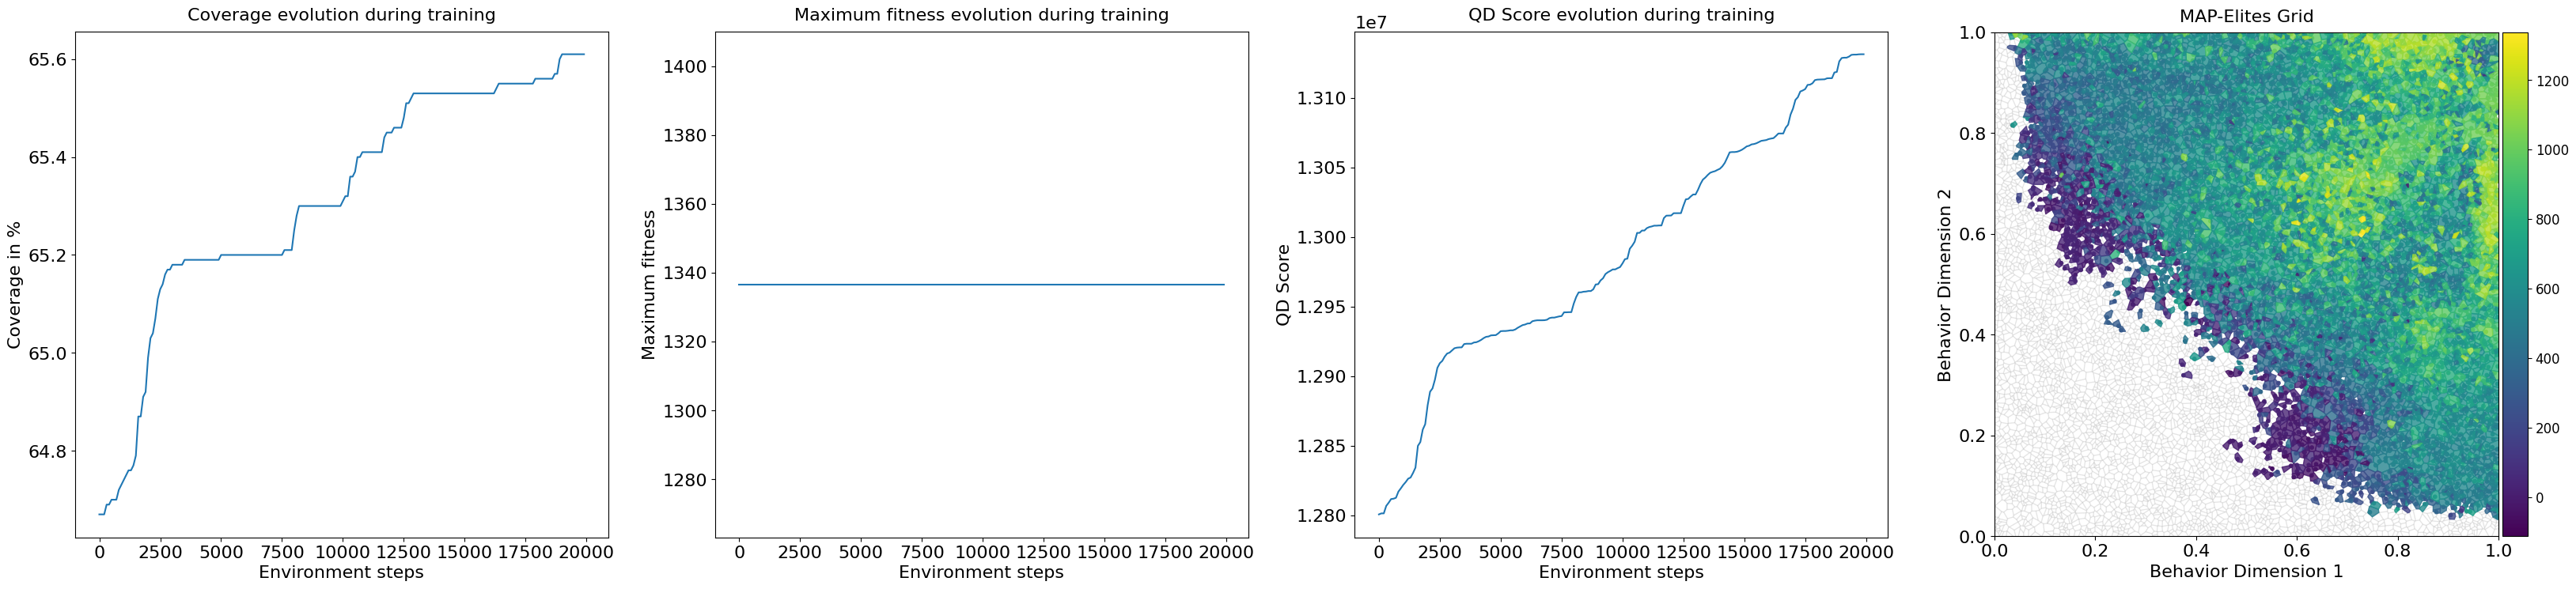

In [ ]:
%matplotlib inline
#@title Visualization

# create the x-axis array
env_steps = jnp.arange(num_iterations) * batch_size

# create the plots and the grid
fig, axes = plot_map_elites_results(
    env_steps=env_steps, metrics=metrics, repertoire=repertoire, min_bd=minval, max_bd=maxval
)